# Benchmark de modèles pour la prédiction électorale

Ce notebook compare plusieurs algorithmes de machine learning pour prédire le gagnant d'une élection (classification) à partir du fichier CSV fusionné. Les scores d'accuracy et l'importance des variables sont affichés pour chaque modèle.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, SGDClassifier, Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# LightGBM et XGBoost
try:
    from lightgbm import LGBMClassifier
except ImportError:
    LGBMClassifier = None
try:
    from xgboost import XGBClassifier
except ImportError:
    XGBClassifier = None

# Chargement des données
csv_path = "../../data/merged_data/data_merged_by_year.csv"
df = pd.read_csv(csv_path, sep=",")

# Encodage One-Hot pour 'Clivage'
one_hot = OneHotEncoder()
clivage_encoded = one_hot.fit_transform(df['Clivage'].values.reshape(-1,1)).toarray()
categories = one_hot.categories_[0]
clivage_df = pd.DataFrame(clivage_encoded, columns = ["Clivage_"+str(category) for category in categories])
df = pd.concat([df, clivage_df], axis=1)

# Sélection des features et de la cible (Tour 1)
feature_cols = ['Taux criminalite', 'Taux chomage', 'Nombre defaillance entreprise'] + list(clivage_df.columns)
X = df[feature_cols]
y = df['Gagnant tour 1']

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split train/test (validation temporelle)
train_years = [1995, 2002, 2007, 2012, 2017]
test_year = 2022
df_train = df[df['Année'].isin(train_years)]
df_test = df[df['Année'] == test_year]
X_train = scaler.fit_transform(df_train[feature_cols])
y_train = df_train['Gagnant tour 1']
X_test = scaler.transform(df_test[feature_cols])
y_test = df_test['Gagnant tour 1']

## Liste des modèles testés
- Random Forest
- Gradient Boosting
- Extra Trees
- Decision Tree
- Logistic Regression (OLS)
- Ridge Classifier
- Lasso (sélection de variables)
- LightGBM
- XGBoost
- SVM
- SGDClassifier
- KNN
- Perceptron
- Deep Neural Network (MLPClassifier)

In [ ]:
models = [
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("Gradient Boosting", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("Extra Trees", ExtraTreesClassifier(n_estimators=100, random_state=42)),
    ("Decision Tree", DecisionTreeClassifier(random_state=42)),
    ("Logistic Regression", LogisticRegression(max_iter=1000, random_state=42)),
    ("Ridge Classifier", RidgeClassifier()),
    ("Lasso", Lasso(alpha=0.01, max_iter=1000)),
    ("SVM", SVC(kernel='rbf', probability=True, random_state=42)),
    ("SGD", SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)),
    ("KNN", KNeighborsClassifier(n_neighbors=5)),
    ("Perceptron", Perceptron(max_iter=1000, random_state=42)),
    ("MLP (Deep NN)", MLPClassifier(hidden_layer_sizes=(100,50), max_iter=1000, random_state=42)),
]
if LGBMClassifier:
    models.append(("LightGBM", LGBMClassifier(n_estimators=100, random_state=42)))
if XGBClassifier:
    models.append(("XGBoost", XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='mlogloss', random_state=42)))

results = []
importances_dict = {}

for name, model in models:
    print(f"\n▶️ {name}")
    if name == "Lasso":
        # Lasso pour la sélection de variables (pas pour la classification multi-classes)
        try:
            model.fit(X_train, y_train.astype('category').cat.codes)
            y_pred = model.predict(X_test)
            y_pred = np.round(y_pred).astype(int)
            acc = accuracy_score(y_test.astype('category').cat.codes, y_pred)
            importances = np.abs(model.coef_)
        except Exception as e:
            print(f"Erreur Lasso: {e}")
            acc = np.nan
            importances = np.zeros(X_train.shape[1])
    else:
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            elif hasattr(model, 'coef_'):
                importances = np.abs(model.coef_[0]) if model.coef_.ndim > 1 else np.abs(model.coef_)
            else:
                importances = np.zeros(X_train.shape[1])
        except Exception as e:
            print(f"Erreur {name}: {e}")
            acc = np.nan
            importances = np.zeros(X_train.shape[1])
    results.append((name, acc))
    importances_dict[name] = importances
    print(f"Accuracy: {acc:.3f}")

# Résumé des scores
results = sorted(results, key=lambda x: (x[1] if x[1] is not None else -1), reverse=True)
print("\nClassement des modèles (accuracy décroissante):")
for name, acc in results:
    print(f"{name:20s}: {acc:.3f}")


 - Random Forest
Accuracy: 0.917

 - Gradient Boosting
Accuracy: 0.917

 - Extra Trees
Accuracy: 0.917

 - Decision Tree
Accuracy: 0.917

 - Logistic Regression
Accuracy: 0.917

 - Ridge Classifier
Accuracy: 0.917

 - Lasso
Accuracy: 0.917

 - SVM
Accuracy: 0.917

 - SGD
Accuracy: 0.917

 - KNN
Accuracy: 0.792

 - Perceptron
Accuracy: 0.750

 - MLP (Deep NN)
Accuracy: 0.917

Classement des modèles (accuracy décroissante):
Random Forest       : 0.917
Gradient Boosting   : 0.917
Extra Trees         : 0.917
Decision Tree       : 0.917
Logistic Regression : 0.917
Ridge Classifier    : 0.917
Lasso               : 0.917
SVM                 : 0.917
SGD                 : 0.917
MLP (Deep NN)       : 0.917
KNN                 : 0.792
Perceptron          : 0.750


## Visualisation des scores d'accuracy

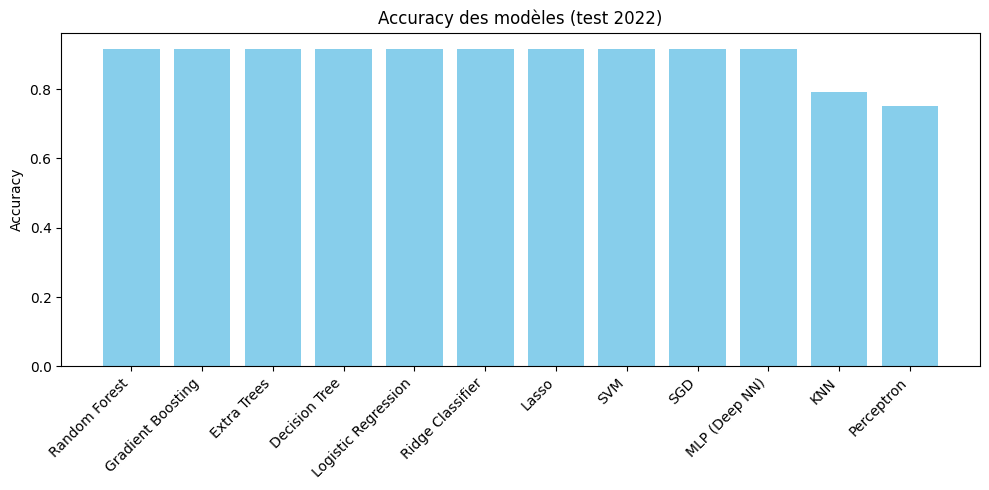

In [4]:
# Barplot des scores
names = [x[0] for x in results]
accs = [x[1] for x in results]
plt.figure(figsize=(10,5))
plt.bar(names, accs, color='skyblue')
plt.ylabel('Accuracy')
plt.title('Accuracy des modèles (test 2022)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Importance des variables pour les meilleurs modèles

Ci-dessous, l'importance des variables pour les 3 meilleurs modèles (si disponible).

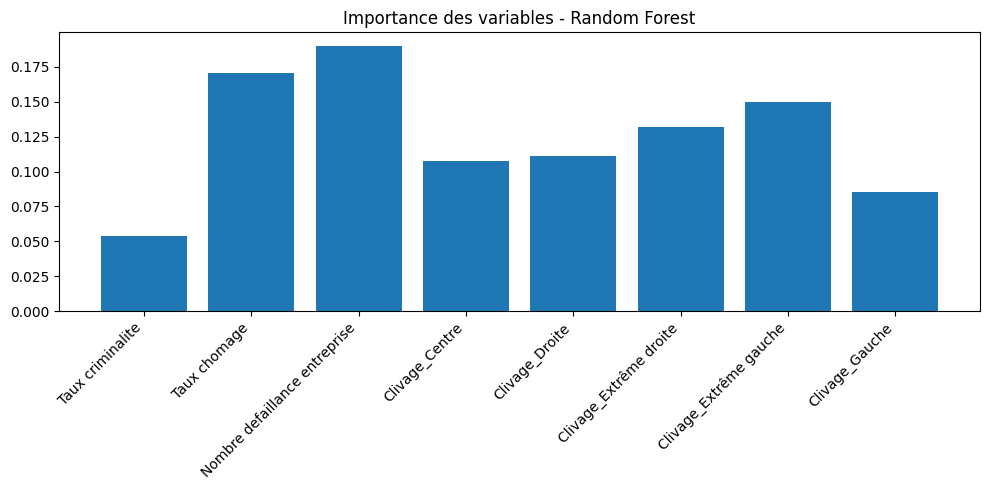

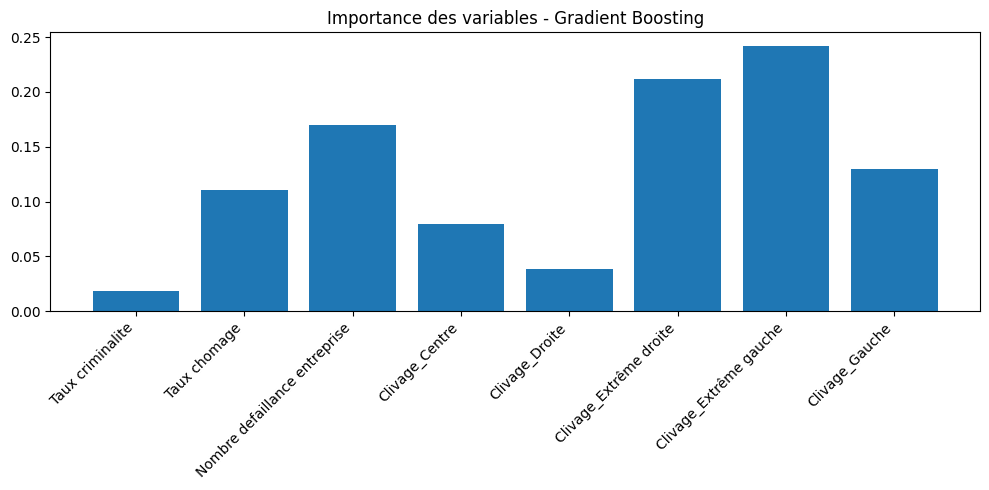

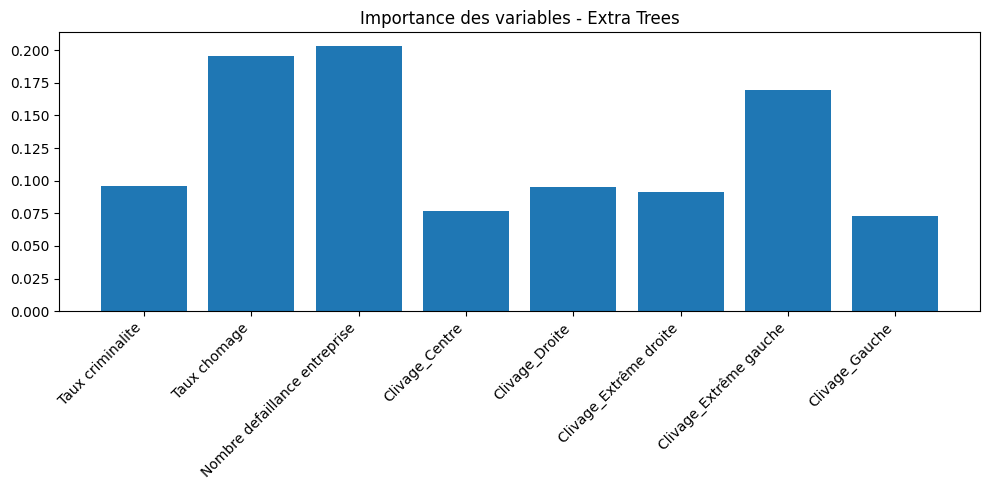

In [5]:
# Affichage de l'importance des variables pour les 3 meilleurs modèles
for name, _ in results[:3]:
    importances = importances_dict.get(name)
    if importances is not None and np.any(importances):
        plt.figure(figsize=(10,5))
        plt.bar(feature_cols, importances)
        plt.xticks(rotation=45, ha='right')
        plt.title(f'Importance des variables - {name}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Pas d'importance de variables disponible pour {name}.")

---

**Remarques :**
- Certains modèles (Lasso, SVM, Perceptron) ne fournissent pas toujours une importance de variable exploitable.
- Pour la régression (Lasso, Ridge), la cible a été encodée en numérique.
- Pour la classification multi-classes, l'accuracy est la métrique principale.
- Pour XGBoost et LightGBM, il faut que les packages soient installés.